In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Read in the dataset

In [2]:
dataset = pd.read_csv("Admission_Predict_Ver1.1.csv")

The dataset has been read successfully. Now it is good that we explore it to understand the features

In [3]:
print(f"The dataset contains {dataset.shape[0]} observations and {dataset.shape[1]} columns")

The dataset contains 500 observations and 9 columns


Let's have a glimpse on a sample of the dataset.

In [4]:
dataset.sample(5)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
404,405,311,101,3,2.0,2.5,7.64,1,0.62
435,436,309,105,2,2.5,4.0,7.68,0,0.55
264,265,325,110,2,3.0,2.5,8.76,1,0.75
60,61,309,100,2,3.0,3.0,8.10,0,0.48
424,425,325,114,5,4.0,5.0,9.46,1,0.91


**Taken from the data description : **
 > The dataset contains several parameters which are considered important during the application for Masters Programs. The parameters included are : 
 > 1. GRE Scores ( out of 340 ) 
 > 2. TOEFL Scores ( out of 120 ) 
 > 3. University Rating ( out of 5 ) 
 > 4. Statement of Purpose and Letter of Recommendation Strength ( out of 5 ) 
 > 5. Undergraduate GPA ( out of 10 ) 
 > 6. Research Experience ( either 0 or 1 ) 
 > 7. Chance of Admit ( ranging from 0 to 1 )

In [5]:
dataset.drop(columns= "Serial No.", axis = 1).describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


# Visualizations

Let's visualize the columns to have insights on the dataset

In [6]:
# Plot settings
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams["figure.dpi"] = 150
plt.style.use("ggplot")

# Histograms

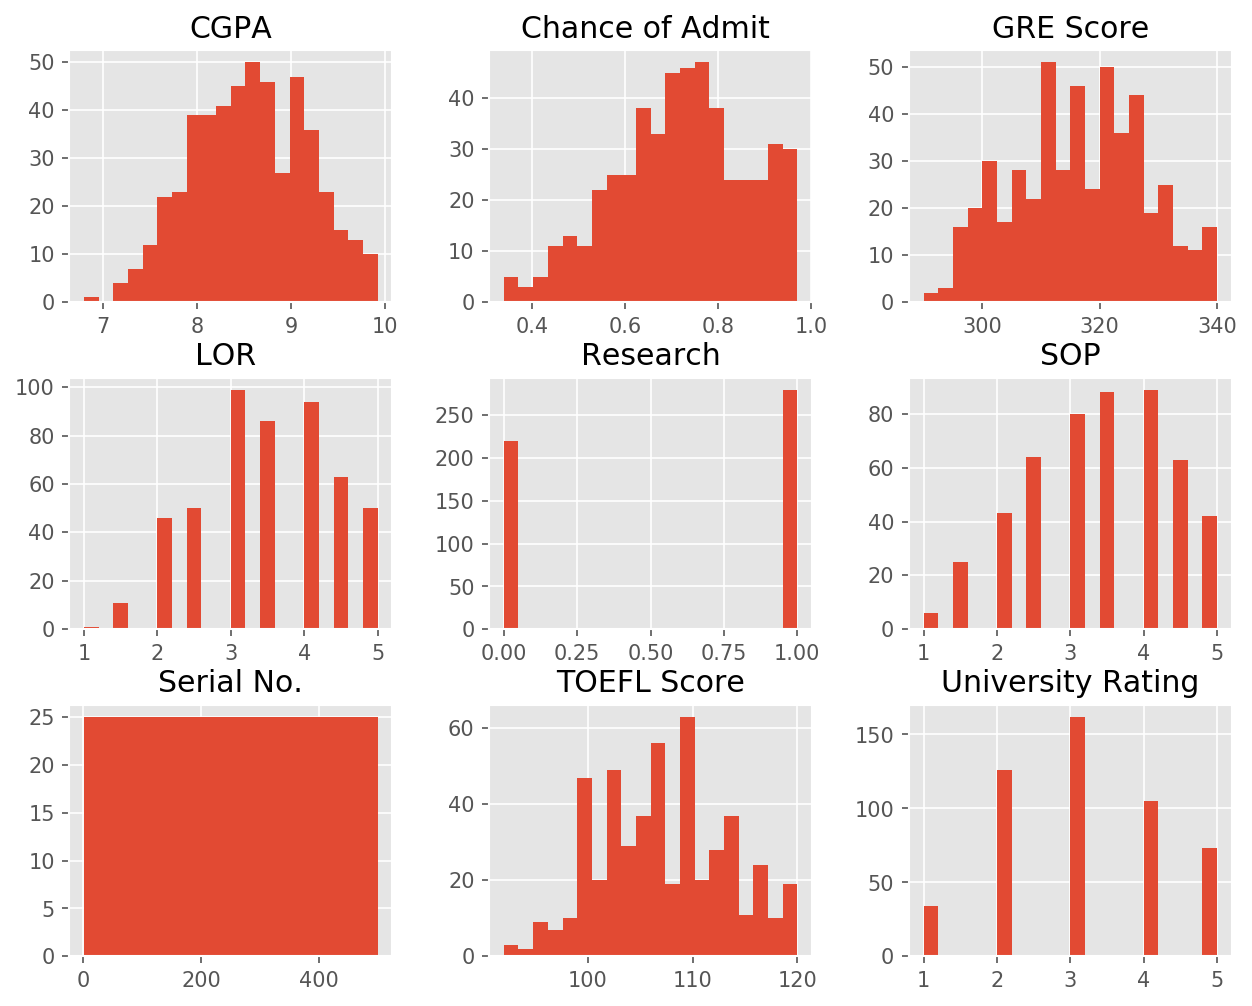

In [7]:
dataset.hist(bins = 20);

## Insights :
- Most of the continuous numerical columns seem to be relatively normally distributed (gaussian distribution). 
- More universities have a ranking of 3/5
- There are more students with a Research experience than without.

# Correlation among continuous variables

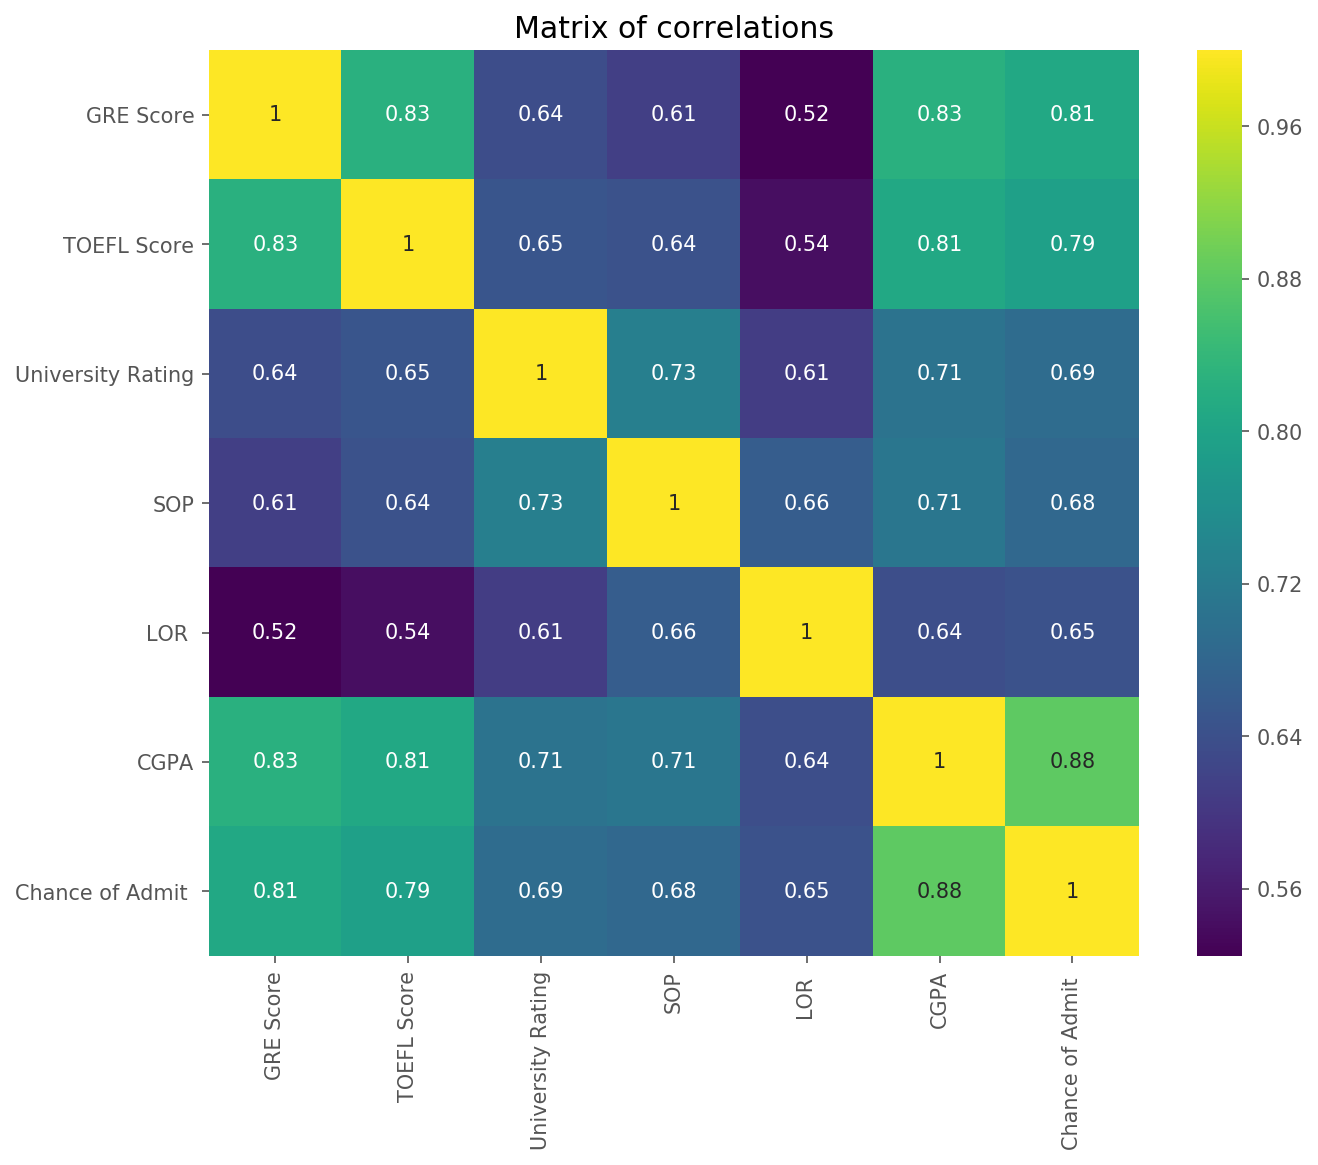

In [8]:
sns.heatmap(dataset.drop(columns= ["Research", "Serial No."]).corr(), 
            cmap= "viridis", annot = True);
plt.title("Matrix of correlations");

All the variables are positively correlated among them. The weakest correlation is around 0.52 (LOR and GRE Score). 

Let's continue exploring the data by taking a look at the pairplot

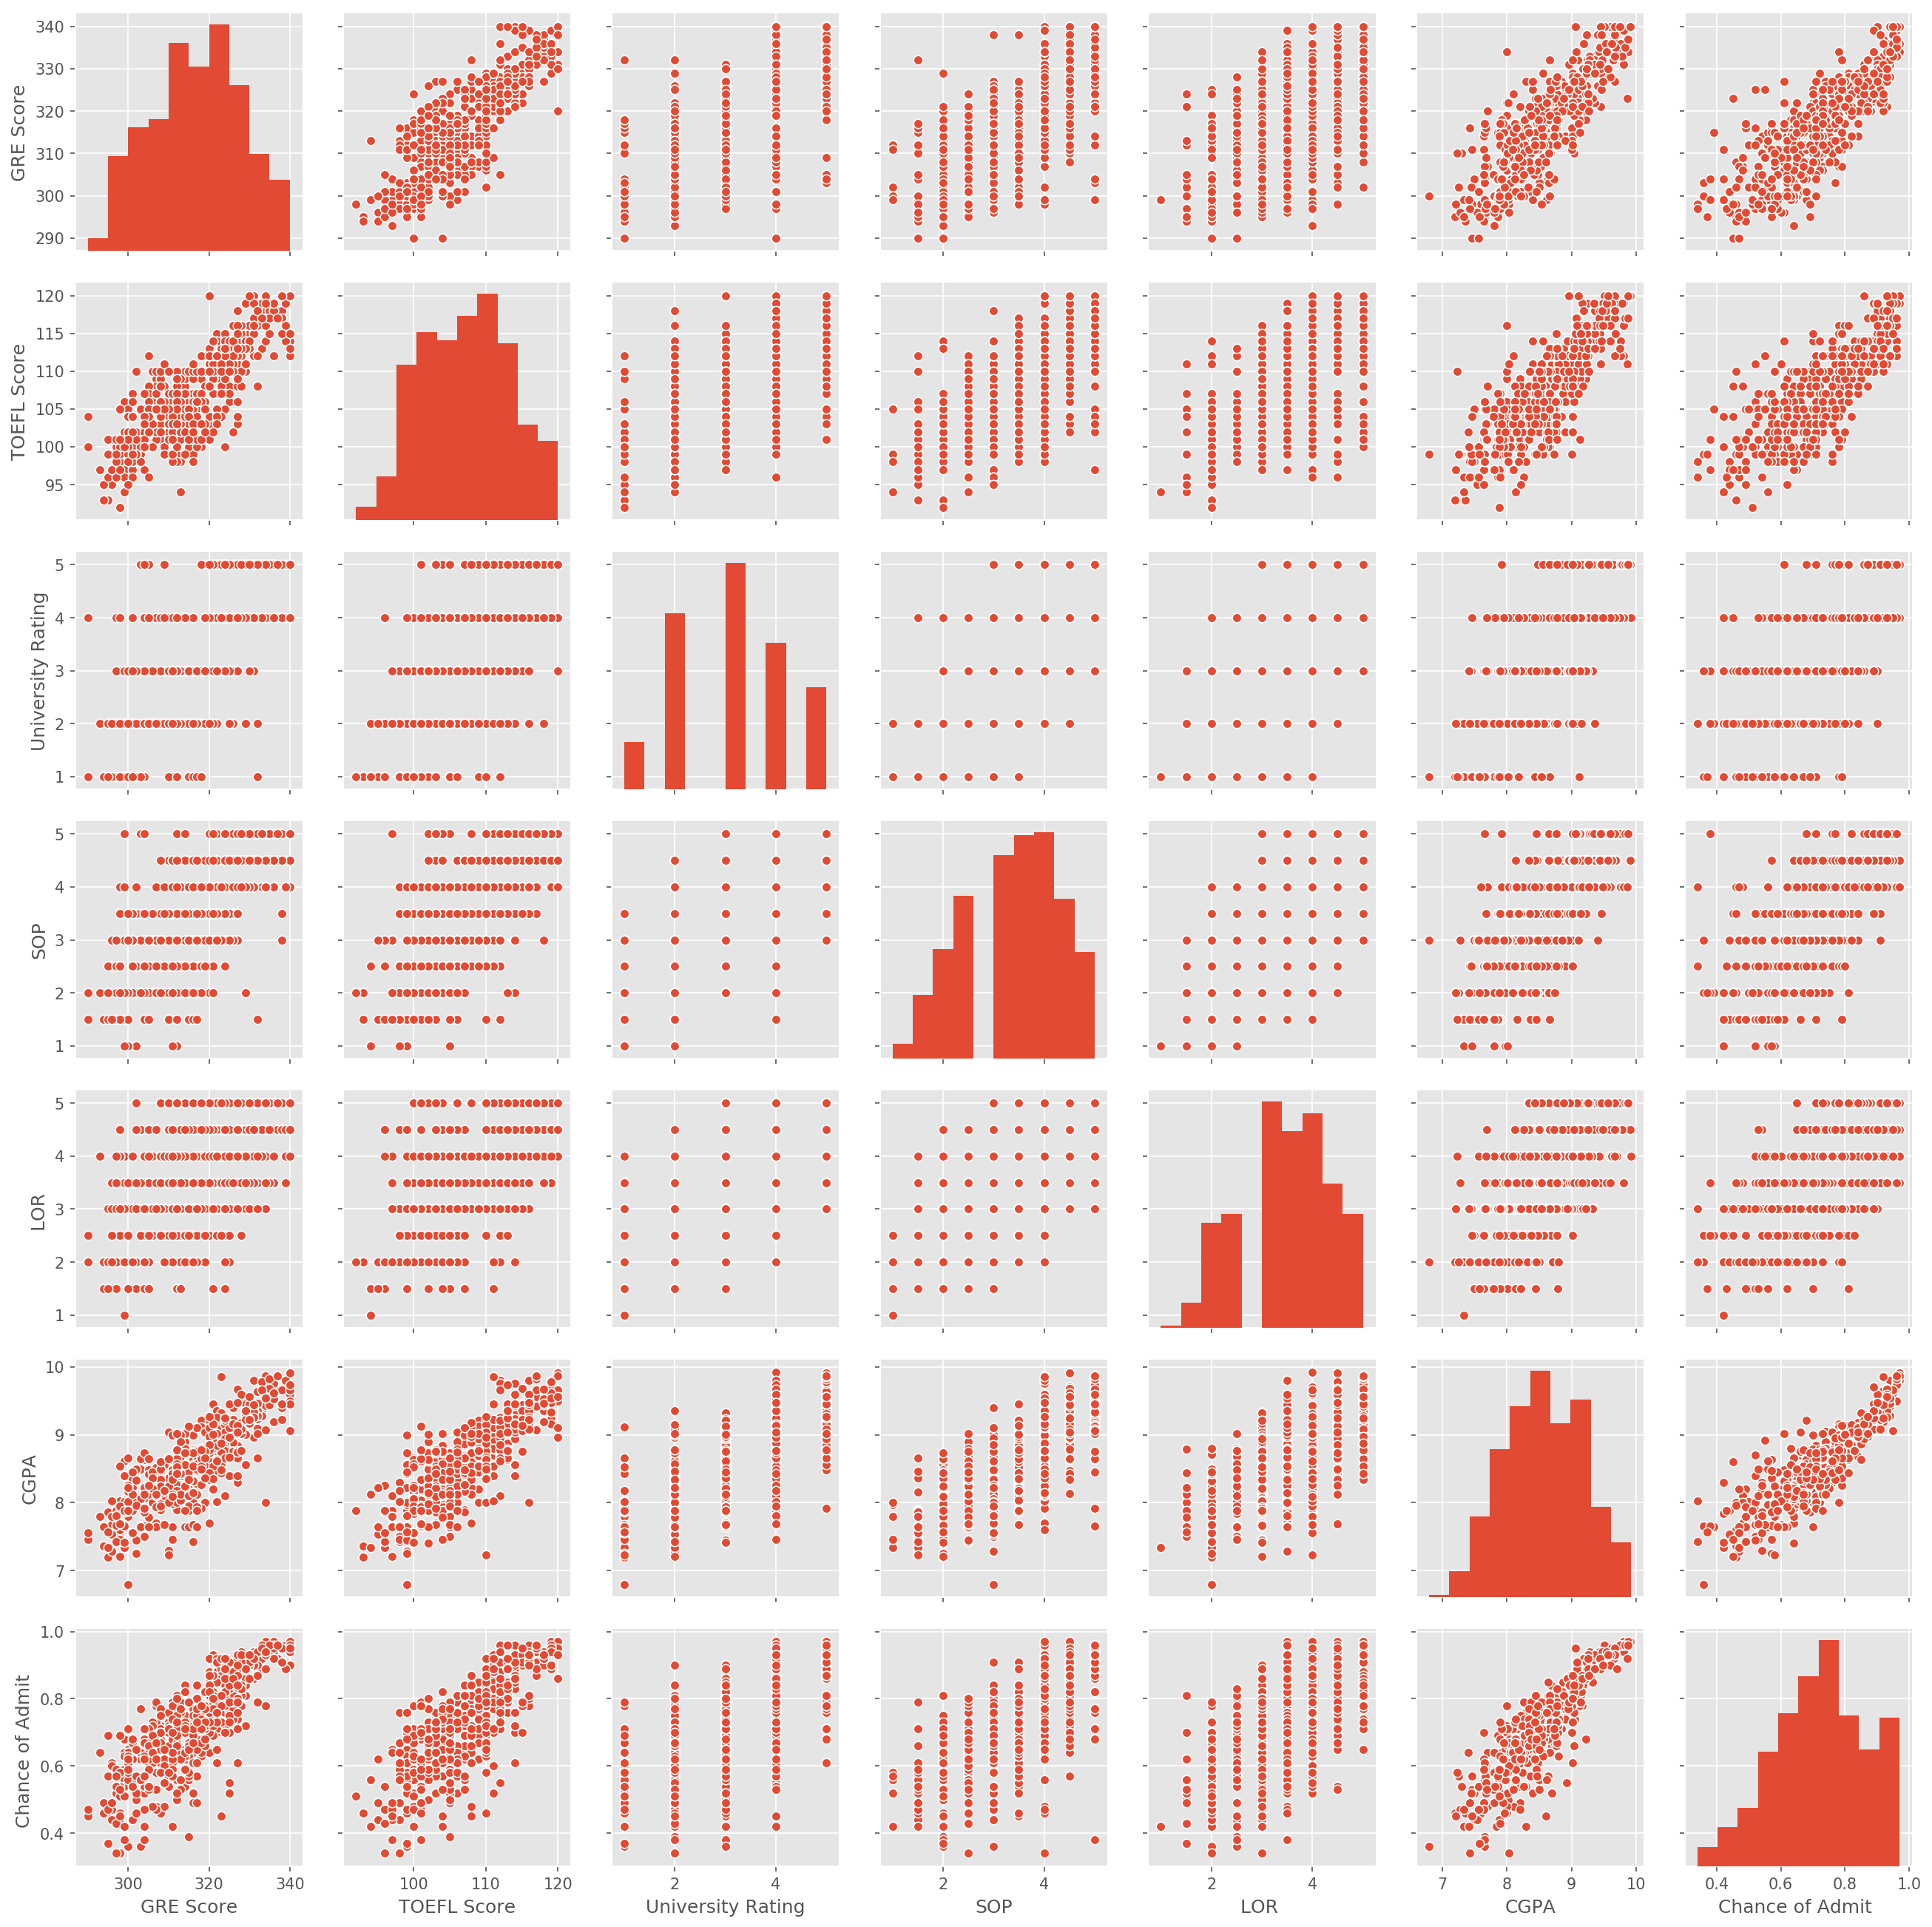

In [9]:
sns.pairplot(dataset.drop(columns= ["Research", "Serial No."]));

# Modelling

My goal here is to predict the chance of admit using a logistic regression.

In [10]:
from statsmodels.api import Logit

In [11]:
train = dataset.drop(columns= ["Serial No."])

The `Research` column need to be transformed into a dummy column

In [12]:
train = pd.get_dummies(train, columns= ["Research"], drop_first= True)

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
train.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit,Research_1
0,337,118,4,4.5,4.5,9.65,0.92,1
1,324,107,4,4.0,4.5,8.87,0.76,1
2,316,104,3,3.0,3.5,8.00,0.72,1
3,322,110,3,3.5,2.5,8.67,0.80,1
4,314,103,2,2.0,3.0,8.21,0.65,0


In [15]:
np.median(dataset["Chance of Admit "])

0.72

Let's create a binary column called `admit` from the `Chance of Admit` column. The threshold is : if `Chance of Admit` > 0.72 then admit = 1

In [16]:
train["admit"] = dataset["Chance of Admit "].apply(lambda x: 1 if x>0.6 else 0)

In [17]:
train["admit"].value_counts()

1    403
0     97
Name: admit, dtype: int64

In [18]:
logistic = LogisticRegression()

In [19]:
X = train.drop(columns= "Chance of Admit ") # remove 
y = train["admit"]

In [20]:
res = logistic.fit(X = X, y = y)

E:\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
prob_admission = []
for not_admitted, admitted in res.predict_proba(X):
    prob_admission.append(admitted)

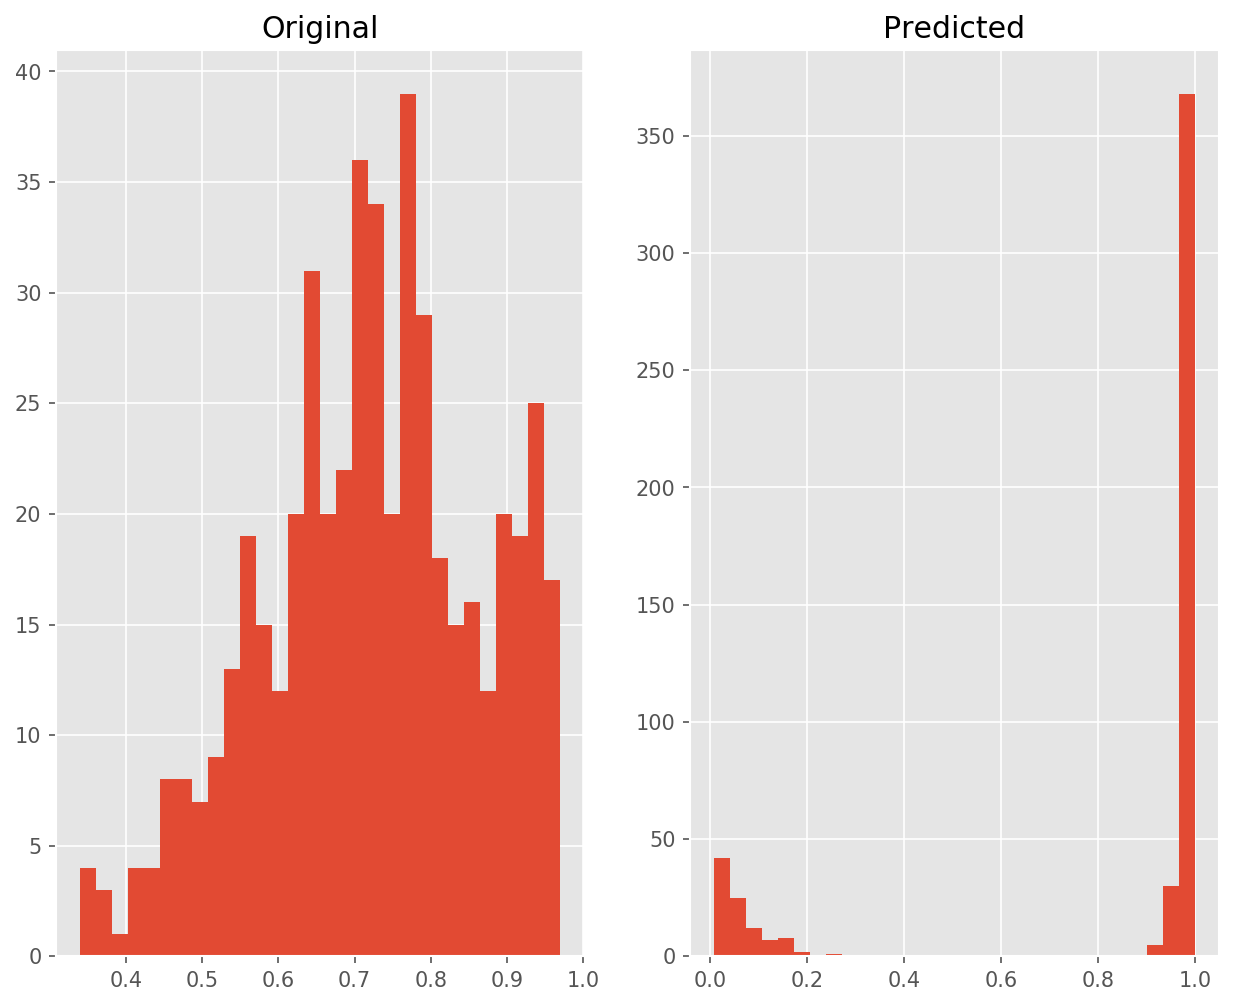

In [22]:
plt.subplot(1,2,1)
plt.hist(dataset["Chance of Admit "], bins = 30)
plt.title("Original")
plt.subplot(1,2,2)
plt.hist(prob_admission, bins = 30)
plt.title("Predicted");

## Accuracy

In [23]:
logit_results = pd.DataFrame({"prob_admission":prob_admission, 
                             "chance_of_admit": dataset["Chance of Admit "],
                             "admitted":res.predict(X)})
logit_results.head()

,prob_admission,chance_of_admit,admitted
0,0.996440,0.92,1
1,0.993823,0.76,1
2,0.977416,0.72,1
3,0.984955,0.80,1
4,0.946737,0.65,1


In [24]:
logit_results["prob_admission"] = np.sort(logit_results["prob_admission"])
logit_results["rank"] = np.arange(1, len(logit_results)+1)

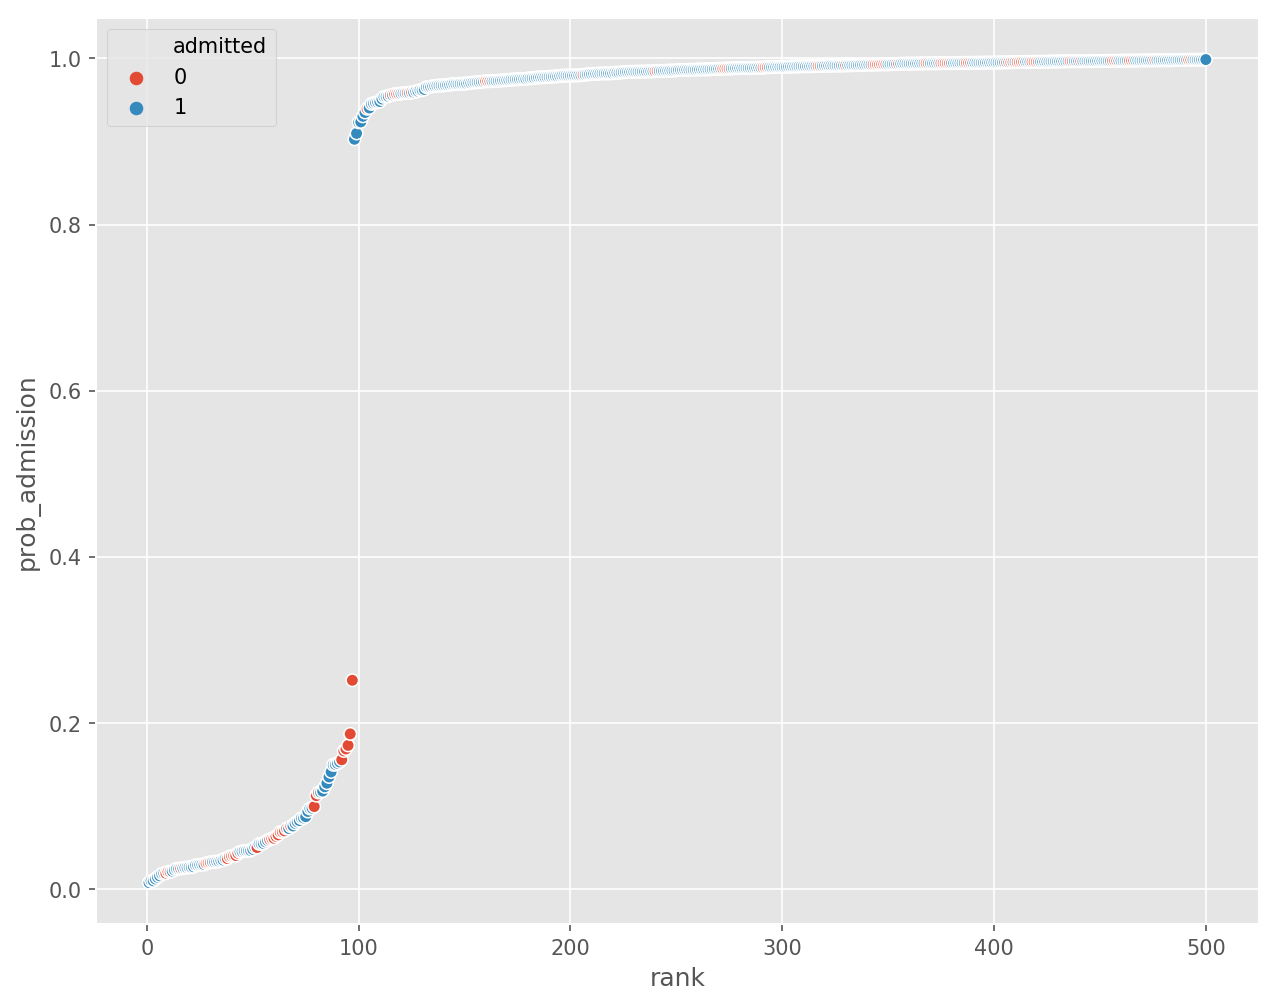

In [25]:
sns.scatterplot(x = "rank", y = "prob_admission", 
                data = logit_results, hue = "admitted");

# Linear regression

In [26]:
train.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit,Research_1,admit
0,337,118,4,4.5,4.5,9.65,0.92,1,1
1,324,107,4,4.0,4.5,8.87,0.76,1,1
2,316,104,3,3.0,3.5,8.00,0.72,1,1
3,322,110,3,3.5,2.5,8.67,0.80,1,1
4,314,103,2,2.0,3.0,8.21,0.65,0,1


In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
X_linreg = train.drop(columns= ["Chance of Admit ", "admit"])
y_linreg = train["Chance of Admit "]

In [29]:
lin_res = LinearRegression()
lin_res = lin_res.fit(X_linreg, y_linreg)

# The shape of the two

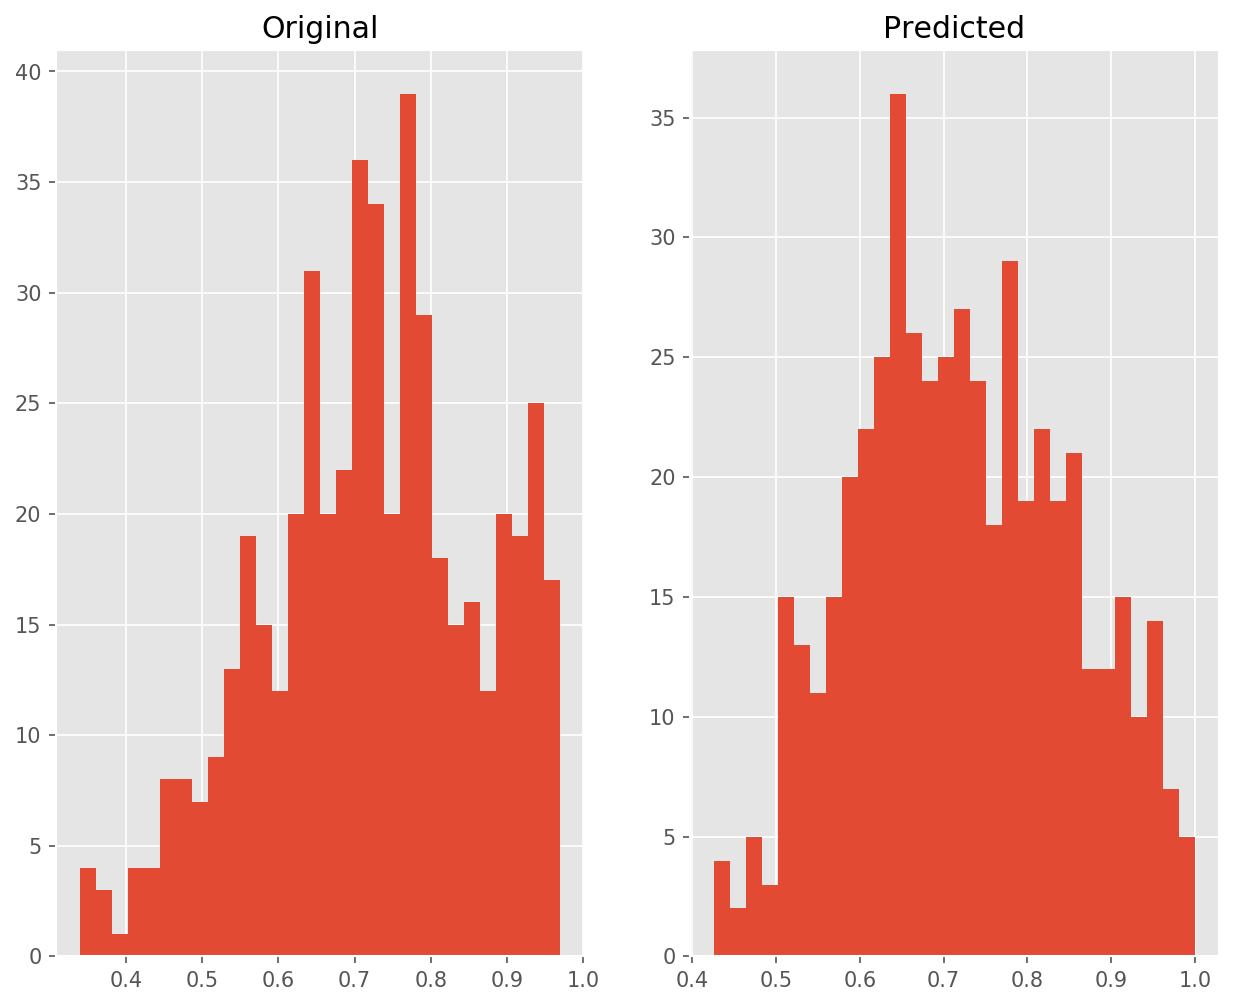

In [30]:
plt.subplot(1,2,1)
plt.hist(dataset["Chance of Admit "], bins = 30)
plt.title("Original")
plt.subplot(1,2,2)
plt.hist(lin_res.predict(X_linreg), bins = 30)
plt.title("Predicted");

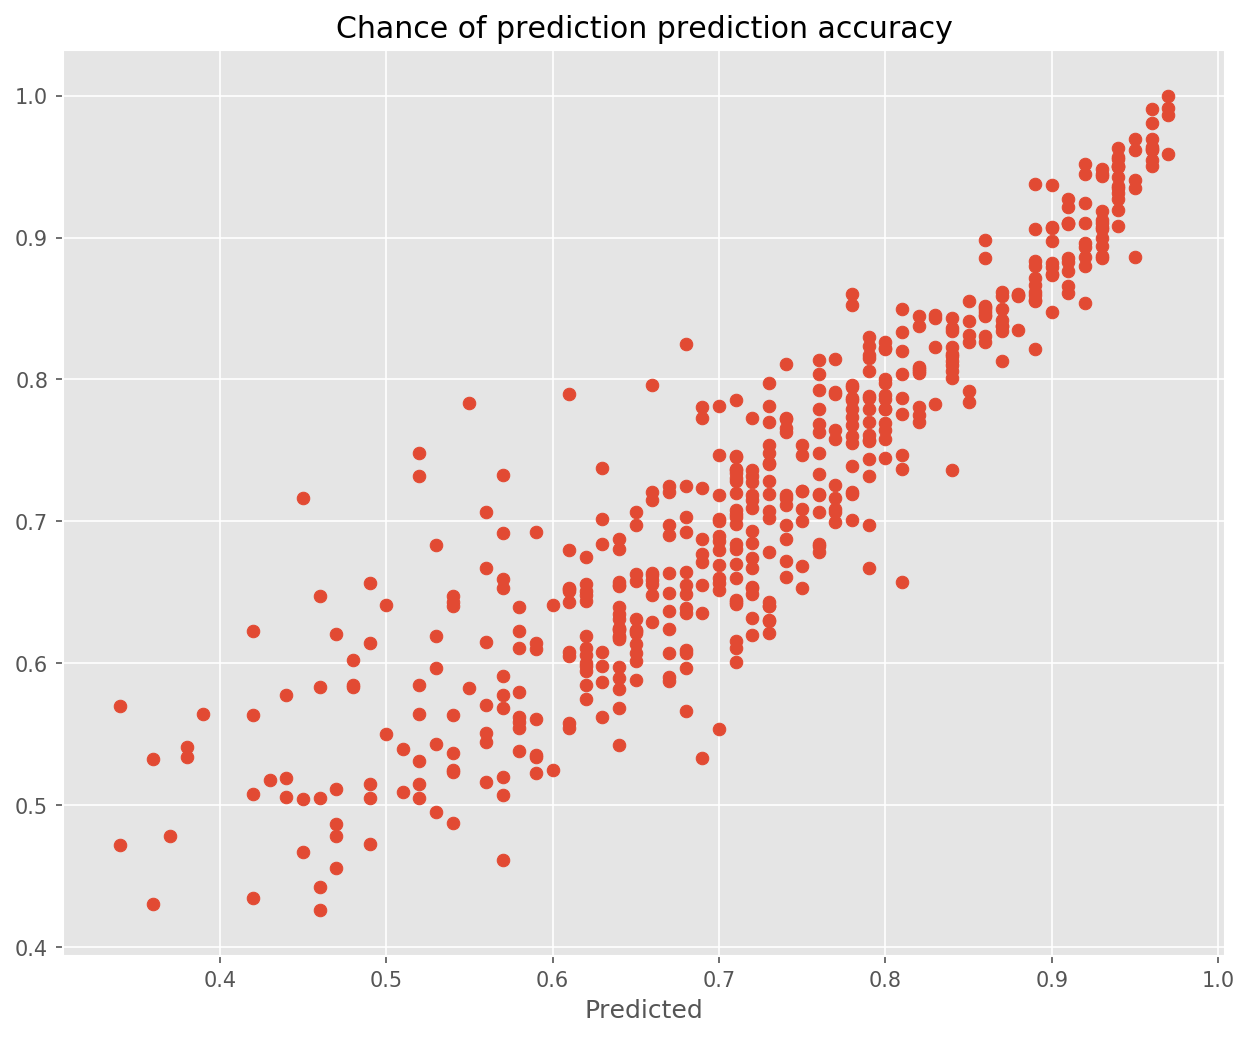

In [31]:
plt.scatter(dataset["Chance of Admit "], lin_res.predict(X_linreg))
plt.title("Chance of prediction prediction accuracy");
plt.xlabel("Original")
plt.xlabel("Predicted");